In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, accuracy_score
import numpy as np
import torch
from sleepdetector import Sleepdetector

# Load Data File
filepath = '../data/data.mat'
mat_file = sio.loadmat(filepath)
n_examples = np.shape(mat_file['sig1'])[0]
x = np.zeros((4, n_examples, 3000, 1))
x[0] = mat_file['sig1']
x[1] = mat_file['sig2']
x[2] = mat_file['sig3']
x[3] = mat_file['sig4']

# Convert numpy array to PyTorch tensor
x = torch.from_numpy(x).float()

# Load CRNNeeg
weights_cnn_path = 'cnn_weights.pth'
weights_lstm_path = 'lstm_weights.pth'
CRNNeeg = Sleepdetector(cnn_path=weights_cnn_path, lstm_path=weights_lstm_path)

# Predict Sleep Stages
y_hat = CRNNeeg.predict(x)

if isinstance(y_hat, int) and y_hat == -1:
    print("Error in prediction. Check input dimensions.")
else:
    # Load actual labels
    labels_file = '../data/labels.mat'
    y_true = sio.loadmat(labels_file)['labels'].flatten() - 1  # Subtract 1 to match 0-4 encoding

    # Ensure y_hat and y_true have the same length
    min_length = min(len(y_hat), len(y_true))
    y_hat = y_hat[:min_length]
    y_true = y_true[:min_length]

    # Compute Cohen's Kappa and Accuracy
    ck = cohen_kappa_score(y_true, y_hat)
    accuracy = accuracy_score(y_true, y_hat)

    print(f"Cohen's Kappa = {ck:.3f}")
    print(f"Accuracy = {100*accuracy:.4f}%")

# Optional: Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_true, label='True')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.title('True vs Predicted Sleep Stages')
plt.xlabel('Time')
plt.ylabel('Sleep Stage')
plt.show()

ImportError: cannot import name 'Sleepdetector' from 'sleepdetector' (/Users/jackkrolik/Library/CloudStorage/OneDrive-Personal/Work/UCSF/Code/eeg-sleepstage-classifier/pytorch/sleepdetector.py)

In [1]:
import h5py
import numpy as np
import torch
from sleepdetector import SleepDetectorCNN, SleepDetectorLSTM

def load_keras_weights(file_path):
    with h5py.File(file_path, 'r') as f:
        return {key: np.array(f[key]) for key in f.keys()}

def convert_cnn_weights(keras_weights, pytorch_model):
    state_dict = pytorch_model.state_dict()
    
    # Drill down into the 'model_weights' group to access each layer
    with h5py.File('cnn_weights.hdf5', 'r') as f:
        model_weights_group = f['model_weights']
        
        # Convert convolutional layers
        for i in range(4):  # 4 input signals
            for j in range(3):  # 3 conv layers per signal
                conv_group = model_weights_group[f'conv1d_{j*4+i+1}/conv1d_{j*4+i+1}']
                bn_group = model_weights_group[f'batch_normalization_{j*4+i+1}/batch_normalization_{j*4+i+1}']
                
                state_dict[f'conv_blocks.{i}.{j}.weight'] = torch.from_numpy(conv_group['kernel:0'][:].transpose(2, 1, 0))
                state_dict[f'conv_blocks.{i}.{j}.bias'] = torch.from_numpy(conv_group['bias:0'][:])
                state_dict[f'conv_blocks.{i}.{j}.1.weight'] = torch.from_numpy(bn_group['gamma:0'][:])
                state_dict[f'conv_blocks.{i}.{j}.1.bias'] = torch.from_numpy(bn_group['beta:0'][:])
                state_dict[f'conv_blocks.{i}.{j}.1.running_mean'] = torch.from_numpy(bn_group['moving_mean:0'][:])
                state_dict[f'conv_blocks.{i}.{j}.1.running_var'] = torch.from_numpy(bn_group['moving_variance:0'][:])
        
        # Convert final dense layer
        dense_group = model_weights_group['dense_1/dense_1']
        state_dict['fc.weight'] = torch.from_numpy(dense_group['kernel:0'][:].T)
        state_dict['fc.bias'] = torch.from_numpy(dense_group['bias:0'][:])
    
    pytorch_model.load_state_dict(state_dict)
    return pytorch_model

def convert_lstm_weights(keras_weights, pytorch_model):
    state_dict = pytorch_model.state_dict()
    
    # Similar approach for LSTM weights
    with h5py.File('lstm_weights.h5', 'r') as f:
        for i in range(4):  # 4 LSTM layers
            forward_group = f[f'bidirectional_{i+1}/bidirectional_{i+1}/forward_lstm_{i+1}']
            backward_group = f[f'bidirectional_{i+1}/bidirectional_{i+1}/backward_lstm_{i+1}']
            
            state_dict[f'lstm_layers.{i}.weight_ih_l0'] = torch.from_numpy(forward_group['kernel:0'][:].T)
            state_dict[f'lstm_layers.{i}.weight_hh_l0'] = torch.from_numpy(forward_group['recurrent_kernel:0'][:].T)
            state_dict[f'lstm_layers.{i}.bias_ih_l0'] = torch.from_numpy(forward_group['bias:0'][:256])
            state_dict[f'lstm_layers.{i}.bias_hh_l0'] = torch.from_numpy(forward_group['bias:0'][256:])
            
            state_dict[f'lstm_layers.{i}.weight_ih_l0_reverse'] = torch.from_numpy(backward_group['kernel:0'][:].T)
            state_dict[f'lstm_layers.{i}.weight_hh_l0_reverse'] = torch.from_numpy(backward_group['recurrent_kernel:0'][:].T)
            state_dict[f'lstm_layers.{i}.bias_ih_l0_reverse'] = torch.from_numpy(backward_group['bias:0'][:256])
            state_dict[f'lstm_layers.{i}.bias_hh_l0_reverse'] = torch.from_numpy(backward_group['bias:0'][256:])
        
        # Convert final dense layer
        dense_group = f['time_distributed_1/time_distributed_1']
        state_dict['fc.weight'] = torch.from_numpy(dense_group['kernel:0'][:].T)
        state_dict['fc.bias'] = torch.from_numpy(dense_group['bias:0'][:])
    
    pytorch_model.load_state_dict(state_dict)
    return pytorch_model

# Load Keras weights
cnn_keras_weights = load_keras_weights('cnn_weights.hdf5')
lstm_keras_weights = load_keras_weights('lstm_weights.h5')

# Initialize PyTorch models
cnn_model = SleepDetectorCNN()
lstm_model = SleepDetectorLSTM()

# Convert weights
cnn_model = convert_cnn_weights(cnn_keras_weights, cnn_model)
lstm_model = convert_lstm_weights(lstm_keras_weights, lstm_model)

# Save PyTorch weights
torch.save(cnn_model.state_dict(), 'cnn_weights.pth')
torch.save(lstm_model.state_dict(), 'lstm_weights.pth')

print("Weight conversion completed. PyTorch weights saved as 'cnn_weights.pth' and 'lstm_weights.pth'.")


RuntimeError: Error(s) in loading state_dict for SleepDetectorCNN:
	Unexpected key(s) in state_dict: "conv_blocks.0.0.1.weight", "conv_blocks.0.0.1.bias", "conv_blocks.0.0.1.running_mean", "conv_blocks.0.0.1.running_var", "conv_blocks.0.1.1.weight", "conv_blocks.0.1.1.bias", "conv_blocks.0.1.1.running_mean", "conv_blocks.0.1.1.running_var", "conv_blocks.0.2.weight", "conv_blocks.0.2.bias", "conv_blocks.0.2.1.weight", "conv_blocks.0.2.1.bias", "conv_blocks.0.2.1.running_mean", "conv_blocks.0.2.1.running_var", "conv_blocks.1.0.1.weight", "conv_blocks.1.0.1.bias", "conv_blocks.1.0.1.running_mean", "conv_blocks.1.0.1.running_var", "conv_blocks.1.1.1.weight", "conv_blocks.1.1.1.bias", "conv_blocks.1.1.1.running_mean", "conv_blocks.1.1.1.running_var", "conv_blocks.1.2.weight", "conv_blocks.1.2.bias", "conv_blocks.1.2.1.weight", "conv_blocks.1.2.1.bias", "conv_blocks.1.2.1.running_mean", "conv_blocks.1.2.1.running_var", "conv_blocks.2.0.1.weight", "conv_blocks.2.0.1.bias", "conv_blocks.2.0.1.running_mean", "conv_blocks.2.0.1.running_var", "conv_blocks.2.1.1.weight", "conv_blocks.2.1.1.bias", "conv_blocks.2.1.1.running_mean", "conv_blocks.2.1.1.running_var", "conv_blocks.2.2.weight", "conv_blocks.2.2.bias", "conv_blocks.2.2.1.weight", "conv_blocks.2.2.1.bias", "conv_blocks.2.2.1.running_mean", "conv_blocks.2.2.1.running_var", "conv_blocks.3.0.1.weight", "conv_blocks.3.0.1.bias", "conv_blocks.3.0.1.running_mean", "conv_blocks.3.0.1.running_var", "conv_blocks.3.1.1.weight", "conv_blocks.3.1.1.bias", "conv_blocks.3.1.1.running_mean", "conv_blocks.3.1.1.running_var", "conv_blocks.3.2.weight", "conv_blocks.3.2.bias", "conv_blocks.3.2.1.weight", "conv_blocks.3.2.1.bias", "conv_blocks.3.2.1.running_mean", "conv_blocks.3.2.1.running_var". 
	size mismatch for conv_blocks.0.1.weight: copying a param with shape torch.Size([16, 8, 8]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.0.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.1.0.weight: copying a param with shape torch.Size([16, 8, 8]) from checkpoint, the shape in current model is torch.Size([8, 1, 50]).
	size mismatch for conv_blocks.1.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.1.1.weight: copying a param with shape torch.Size([32, 16, 8]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.1.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.2.0.weight: copying a param with shape torch.Size([32, 16, 8]) from checkpoint, the shape in current model is torch.Size([8, 1, 50]).
	size mismatch for conv_blocks.2.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.2.1.weight: copying a param with shape torch.Size([8, 1, 50]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.3.1.weight: copying a param with shape torch.Size([16, 8, 8]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.3.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).

In [23]:
import h5py
import numpy as np
import torch
from sleepdetector import SleepDetectorCNN, SleepDetectorLSTM

def load_keras_weights_cnn(file_path):
    with h5py.File(file_path, 'r') as f:
        model_weights = {}
        for layer in f['model_weights'].keys():
            if layer.startswith('conv1d') or layer.startswith('batch_normalization'):
                nested_group = f['model_weights'][layer][layer]
                layer_weights = {key: np.array(nested_group[key]) for key in nested_group.keys()}
                model_weights[layer] = layer_weights
            elif layer == 'dense_1':
                dense_group = f['model_weights']['dense_1']['dense_1']
                model_weights['dense_1'] = {key: np.array(dense_group[key]) for key in dense_group.keys()}
        return model_weights

def load_keras_weights_lstm(file_path):
    with h5py.File(file_path, 'r') as f:
        model_weights = {}
        for top_key in f.keys():
            if isinstance(f[top_key], h5py.Group):
                if top_key.startswith('bidirectional') or top_key == 'time_distributed_1':
                    model_weights[top_key] = {}
                    for sub_key in f[top_key][top_key].keys():
                        layer_group = f[top_key][top_key][sub_key]
                        if isinstance(layer_group, h5py.Group):
                            layer_weights = {key: np.array(layer_group[key]) for key in layer_group.keys()}
                            model_weights[top_key][sub_key] = layer_weights
                        else:
                            # For datasets directly under the group, just add them
                            model_weights[top_key][sub_key] = np.array(layer_group)
            else:
                # If there's no nested group, just add the dataset
                model_weights[top_key] = np.array(f[top_key])
        return model_weights

def convert_cnn_weights(keras_weights, pytorch_model):
    state_dict = pytorch_model.state_dict()

    # Convert convolutional layers
    for i in range(4):  # 4 input signals
        for j in range(3):  # 3 conv layers per signal
            layer_num = j*4 + i + 1
            conv_key = f'conv1d_{layer_num}'
            bn_key = f'batch_normalization_{layer_num}'

            if conv_key in keras_weights and bn_key in keras_weights:
                conv_weights = keras_weights[conv_key]
                bn_weights = keras_weights[bn_key]

                # Adjust keys for PyTorch model
                if 'kernel:0' in conv_weights:
                    state_dict[f'conv_blocks.{i}.{j}.weight'] = torch.from_numpy(conv_weights['kernel:0'].transpose(2, 1, 0))
                else:
                    print(f"Warning: 'kernel:0' not found in {conv_key}")

                if 'bias:0' in conv_weights:
                    state_dict[f'conv_blocks.{i}.{j}.bias'] = torch.from_numpy(conv_weights['bias:0'])
                else:
                    print(f"Warning: 'bias:0' not found in {conv_key}")

                if f'conv_blocks.{i}.{j}.1.weight' in state_dict:
                    if 'gamma:0' in bn_weights:
                        state_dict[f'conv_blocks.{i}.{j}.1.weight'] = torch.from_numpy(bn_weights['gamma:0'])
                    else:
                        print(f"Warning: 'gamma:0' not found in {bn_key}")

                if f'conv_blocks.{i}.{j}.1.bias' in state_dict:
                    if 'beta:0' in bn_weights:
                        state_dict[f'conv_blocks.{i}.{j}.1.bias'] = torch.from_numpy(bn_weights['beta:0'])
                    else:
                        print(f"Warning: 'beta:0' not found in {bn_key}")

                if f'conv_blocks.{i}.{j}.1.running_mean' in state_dict:
                    if 'moving_mean:0' in bn_weights:
                        state_dict[f'conv_blocks.{i}.{j}.1.running_mean'] = torch.from_numpy(bn_weights['moving_mean:0'])
                    else:
                        print(f"Warning: 'moving_mean:0' not found in {bn_key}")

                if f'conv_blocks.{i}.{j}.1.running_var' in state_dict:
                    if 'moving_variance:0' in bn_weights:
                        state_dict[f'conv_blocks.{i}.{j}.1.running_var'] = torch.from_numpy(bn_weights['moving_variance:0'])
                    else:
                        print(f"Warning: 'moving_variance:0' not found in {bn_key}")

    # Convert final dense layer
    dense_weights = keras_weights['dense_1']
    if 'kernel:0' in dense_weights:
        state_dict['fc.weight'] = torch.from_numpy(dense_weights['kernel:0'].T)
    else:
        print(f"Warning: 'kernel:0' not found in dense_1")
    if 'bias:0' in dense_weights:
        state_dict['fc.bias'] = torch.from_numpy(dense_weights['bias:0'])
    else:
        print(f"Warning: 'bias:0' not found in dense_1")

    # Load state dict with strict=False to ignore unexpected/missing keys
    pytorch_model.load_state_dict(state_dict, strict=False)
    return pytorch_model

def convert_lstm_weights(keras_weights, pytorch_model):
    state_dict = pytorch_model.state_dict()

    # Convert LSTM layers
    for i in range(4):  # 4 LSTM layers
        forward_lstm_key = f'bidirectional_{i+1}'
        backward_lstm_key = f'bidirectional_{i+1}'

        forward_weights = keras_weights[forward_lstm_key][f'forward_lstm_{i+1}']
        backward_weights = keras_weights[backward_lstm_key][f'backward_lstm_{i+1}']

        # Forward LSTM
        state_dict[f'lstm_layers.{i}.weight_ih_l0'] = torch.from_numpy(forward_weights['kernel:0'].T)
        state_dict[f'lstm_layers.{i}.weight_hh_l0'] = torch.from_numpy(forward_weights['recurrent_kernel:0'].T)
        state_dict[f'lstm_layers.{i}.bias_ih_l0'] = torch.from_numpy(forward_weights['bias:0'][:256])
        state_dict[f'lstm_layers.{i}.bias_hh_l0'] = torch.from_numpy(forward_weights['bias:0'][256:])

        # Backward LSTM
        state_dict[f'lstm_layers.{i}.weight_ih_l0_reverse'] = torch.from_numpy(backward_weights['kernel:0'].T)
        state_dict[f'lstm_layers.{i}.weight_hh_l0_reverse'] = torch.from_numpy(backward_weights['recurrent_kernel:0'].T)
        state_dict[f'lstm_layers.{i}.bias_ih_l0_reverse'] = torch.from_numpy(backward_weights['bias:0'][:256])
        state_dict[f'lstm_layers.{i}.bias_hh_l0_reverse'] = torch.from_numpy(backward_weights['bias:0'][256:])

    # Convert final dense layer
    dense_weights = keras_weights['time_distributed_1']['time_distributed_1']
    state_dict['fc.weight'] = torch.from_numpy(dense_weights['kernel:0'].T)
    state_dict['fc.bias'] = torch.from_numpy(dense_weights['bias:0'])

    # Load state dict with strict=False to ignore unexpected/missing keys
    pytorch_model.load_state_dict(state_dict, strict=False)
    return pytorch_model

# Load Keras weights
cnn_keras_weights = load_keras_weights_cnn('cnn_weights.hdf5')
lstm_keras_weights = load_keras_weights_lstm('lstm_weights.h5')

# Initialize PyTorch models
cnn_model = SleepDetectorCNN()
lstm_model = SleepDetectorLSTM()

# Convert weights
cnn_model = convert_cnn_weights(cnn_keras_weights, cnn_model)
lstm_model = convert_lstm_weights(lstm_keras_weights, lstm_model)

# Save PyTorch weights
torch.save(cnn_model.state_dict(), 'cnn_weights.pth')
torch.save(lstm_model.state_dict(), 'lstm_weights.pth')

print("Weight conversion completed. PyTorch weights saved as 'cnn_weights.pth' and 'lstm_weights.pth'.")


RuntimeError: Error(s) in loading state_dict for SleepDetectorCNN:
	size mismatch for conv_blocks.0.1.weight: copying a param with shape torch.Size([16, 8, 8]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.0.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.1.0.weight: copying a param with shape torch.Size([16, 8, 8]) from checkpoint, the shape in current model is torch.Size([8, 1, 50]).
	size mismatch for conv_blocks.1.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.1.1.weight: copying a param with shape torch.Size([32, 16, 8]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.1.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.2.0.weight: copying a param with shape torch.Size([32, 16, 8]) from checkpoint, the shape in current model is torch.Size([8, 1, 50]).
	size mismatch for conv_blocks.2.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.2.1.weight: copying a param with shape torch.Size([8, 1, 50]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.3.1.weight: copying a param with shape torch.Size([16, 8, 8]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_blocks.3.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).

In [3]:
import torch
import h5py
import numpy as np
import torch.nn.functional as F
import torch.nn as nn


class SleepDetectorCNN(nn.Module):
    def __init__(self):
        super(SleepDetectorCNN, self).__init__()

        # 4 input signals
        self.conv_blocks = nn.ModuleList()
        
        for _ in range(4):
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=8, kernel_size=50),
                nn.ReLU(),
                nn.BatchNorm1d(8),
                nn.MaxPool1d(kernel_size=8),

                nn.Conv1d(in_channels=8, out_channels=16, kernel_size=8),
                nn.ReLU(),
                nn.BatchNorm1d(16),
                nn.MaxPool1d(kernel_size=8),

                nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8),
                nn.ReLU(),
                nn.BatchNorm1d(32),
                nn.MaxPool1d(kernel_size=8),
            )
            self.conv_blocks.append(conv_block)

        # Flatten and fully connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4 * 32 * (640 // (8*8*8)), 5)  # Assuming final pooled size is 640/(8*8*8)
    
    def forward(self, x):
        outputs = []
        for i in range(4):
            out = self.conv_blocks[i](x[i])
            outputs.append(out)
        
        x = torch.cat(outputs, dim=1)
        x = self.flatten(x)
        x = self.fc(x)
        return F.softmax(x, dim=1)


class SleepDetectorLSTM(nn.Module):
    def __init__(self):
        super(SleepDetectorLSTM, self).__init__()
        
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size=640, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True),
            nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True),
            nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True),
            nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True),
        ])
        
        self.fc = nn.Linear(128, 5)
    
    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        
        x = self.fc(x[:, -1, :])
        return F.softmax(x, dim=1)


# Load the Keras CNN weights
def load_keras_weights_cnn(file_path):
    with h5py.File(file_path, 'r') as f:
        model_weights = {}
        for layer_name in ['conv1d_1', 'conv1d_2', 'conv1d_3', 'conv1d_4', 'conv1d_5',
                           'conv1d_6', 'conv1d_7', 'conv1d_8', 'conv1d_9', 'conv1d_10',
                           'conv1d_11', 'conv1d_12', 'dense_1']:
            try:
                layer_group = f[f'{layer_name}/{layer_name}']
                layer_weights = {key: np.array(layer_group[key]) for key in layer_group.keys()}
                model_weights[layer_name] = layer_weights
            except KeyError:
                print(f"Warning: Missing {layer_name}/{layer_name} in Keras weights.")
        for bn_name in ['batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3',
                        'batch_normalization_4', 'batch_normalization_5', 'batch_normalization_6',
                        'batch_normalization_7', 'batch_normalization_8', 'batch_normalization_9',
                        'batch_normalization_10', 'batch_normalization_11', 'batch_normalization_12']:
            try:
                bn_group = f[f'{bn_name}/{bn_name}']
                bn_weights = {key: np.array(bn_group[key]) for key in bn_group.keys()}
                model_weights[bn_name] = bn_weights
            except KeyError:
                print(f"Warning: Missing {bn_name}/{bn_name} in Keras weights.")
        return model_weights

# Load the Keras LSTM weights
def load_keras_weights_lstm(file_path):
    with h5py.File(file_path, 'r') as f:
        model_weights = {}
        for layer_name in ['bidirectional_1', 'bidirectional_2', 'bidirectional_3', 'bidirectional_4']:
            model_weights[layer_name] = {}
            for sub_layer_name in ['forward_lstm_1', 'backward_lstm_1', 'forward_lstm_2', 'backward_lstm_2',
                                   'forward_lstm_3', 'backward_lstm_3', 'forward_lstm_4', 'backward_lstm_4']:
                try:
                    layer_group = f[f'{layer_name}/{layer_name}/{sub_layer_name}']
                    layer_weights = {key: np.array(layer_group[key]) for key in layer_group.keys()}
                    model_weights[layer_name][sub_layer_name] = layer_weights
                except KeyError:
                    print(f"Warning: Missing {layer_name}/{layer_name}/{sub_layer_name} in Keras weights.")
        try:
            td_group = f['time_distributed_1/time_distributed_1']
            td_weights = {key: np.array(td_group[key]) for key in td_group.keys()}
            model_weights['time_distributed_1'] = td_weights
        except KeyError:
            print(f"Warning: Missing time_distributed_1/time_distributed_1 in Keras weights.")
        return model_weights







In [6]:
def convert_cnn_weights(keras_weights, pytorch_model):
    state_dict = pytorch_model.state_dict()

    for i in range(1, 13):  # Assuming 12 conv layers
        conv_key = f'model_weights/conv1d_{i}/conv1d_{i}'
        bn_key = f'model_weights/batch_normalization_{i}/batch_normalization_{i}'

        if conv_key in keras_weights and bn_key in keras_weights:
            print(f"Loading weights for {conv_key} and {bn_key}")
            conv_weights = keras_weights[conv_key]
            bn_weights = keras_weights[bn_key]

            state_dict[f'conv_blocks.{i-1}.0.weight'] = torch.from_numpy(conv_weights['kernel:0'].transpose(2, 1, 0))
            state_dict[f'conv_blocks.{i-1}.0.bias'] = torch.from_numpy(conv_weights['bias:0'])
            state_dict[f'conv_blocks.{i-1}.1.weight'] = torch.from_numpy(bn_weights['gamma:0'])
            state_dict[f'conv_blocks.{i-1}.1.bias'] = torch.from_numpy(bn_weights['beta:0'])
            state_dict[f'conv_blocks.{i-1}.1.running_mean'] = torch.from_numpy(bn_weights['moving_mean:0'])
            state_dict[f'conv_blocks.{i-1}.1.running_var'] = torch.from_numpy(bn_weights['moving_variance:0'])
        else:
            print(f"Warning: Missing {conv_key} or {bn_key} in Keras weights.")

    dense_key = 'model_weights/dense_1/dense_1'
    if dense_key in keras_weights:
        print(f"Loading weights for {dense_key}")
        dense_weights = keras_weights[dense_key]
        state_dict['fc.weight'] = torch.from_numpy(dense_weights['kernel:0'].T)
        state_dict['fc.bias'] = torch.from_numpy(dense_weights['bias:0'])
    else:
        print(f"Warning: Missing {dense_key} in Keras weights.")

    pytorch_model.load_state_dict(state_dict, strict=False)
    return pytorch_model

def convert_lstm_weights(keras_weights, pytorch_model):
    state_dict = pytorch_model.state_dict()

    for i in range(1, 5):
        lstm_key = f'model_weights/bidirectional_{i}/bidirectional_{i}'
        if lstm_key in keras_weights:
            print(f"Loading weights for {lstm_key}")
            forward_key = f'{lstm_key}/forward_lstm_{i}'
            backward_key = f'{lstm_key}/backward_lstm_{i}'

            if forward_key in keras_weights and backward_key in keras_weights:
                forward_weights = keras_weights[forward_key]
                backward_weights = keras_weights[backward_key]

                state_dict[f'lstm_blocks.{i-1}.weight_ih_l0'] = torch.from_numpy(forward_weights['kernel:0'].T)
                state_dict[f'lstm_blocks.{i-1}.weight_hh_l0'] = torch.from_numpy(forward_weights['recurrent_kernel:0'].T)
                state_dict[f'lstm_blocks.{i-1}.bias_ih_l0'] = torch.from_numpy(forward_weights['bias:0'])

                state_dict[f'lstm_blocks.{i-1}.weight_ih_l0_reverse'] = torch.from_numpy(backward_weights['kernel:0'].T)
                state_dict[f'lstm_blocks.{i-1}.weight_hh_l0_reverse'] = torch.from_numpy(backward_weights['recurrent_kernel:0'].T)
                state_dict[f'lstm_blocks.{i-1}.bias_ih_l0_reverse'] = torch.from_numpy(backward_weights['bias:0'])
            else:
                print(f"Warning: Missing {forward_key} or {backward_key} in Keras weights.")
        else:
            print(f"Warning: Missing {lstm_key} in Keras weights.")

    dense_key = 'model_weights/time_distributed_1/time_distributed_1'
    if dense_key in keras_weights:
        print(f"Loading weights for {dense_key}")
        dense_weights = keras_weights[dense_key]
        state_dict['fc.weight'] = torch.from_numpy(dense_weights['kernel:0'].T)
        state_dict['fc.bias'] = torch.from_numpy(dense_weights['bias:0'])
    else:
        print(f"Warning: Missing {dense_key} in Keras weights.")

    pytorch_model.load_state_dict(state_dict, strict=False)
    return pytorch_model



In [7]:


# Load Keras weights
cnn_keras_weights = load_keras_weights_cnn('cnn_weights.hdf5')
lstm_keras_weights = load_keras_weights_lstm('lstm_weights.h5')

# Initialize PyTorch models
cnn_model = SleepDetectorCNN()
lstm_model = SleepDetectorLSTM()

# Convert weights
cnn_model = convert_cnn_weights(cnn_keras_weights, cnn_model)
lstm_model = convert_lstm_weights(lstm_keras_weights, lstm_model)

# Save PyTorch weights
if cnn_model:
    torch.save(cnn_model.state_dict(), 'cnn_weights.pth')
else:
    print("Error: CNN model is None. Conversion failed.")

if lstm_model:
    torch.save(lstm_model.state_dict(), 'lstm_weights.pth')
else:
    print("Error: LSTM model is None. Conversion failed.")

In [9]:
import h5py

def print_hdf5_structure(file_path):
    with h5py.File(file_path, 'r') as f:
        def print_structure(name, obj):
            print(name)
        f.visititems(print_structure)

print("CNN Weights Structure:")
print_hdf5_structure('cnn_weights.hdf5')

print("LSTM Weights Structure:")
print_hdf5_structure('lstm_weights.h5')


CNN Weights Structure:
model_weights
model_weights/activation_1
model_weights/activation_10
model_weights/activation_11
model_weights/activation_12
model_weights/activation_2
model_weights/activation_3
model_weights/activation_4
model_weights/activation_5
model_weights/activation_6
model_weights/activation_7
model_weights/activation_8
model_weights/activation_9
model_weights/batch_normalization_1
model_weights/batch_normalization_1/batch_normalization_1
model_weights/batch_normalization_1/batch_normalization_1/beta:0
model_weights/batch_normalization_1/batch_normalization_1/gamma:0
model_weights/batch_normalization_1/batch_normalization_1/moving_mean:0
model_weights/batch_normalization_1/batch_normalization_1/moving_variance:0
model_weights/batch_normalization_10
model_weights/batch_normalization_10/batch_normalization_10
model_weights/batch_normalization_10/batch_normalization_10/beta:0
model_weights/batch_normalization_10/batch_normalization_10/gamma:0
model_weights/batch_normalizati

In [17]:
import h5py
import torch
import torch.nn as nn

# Open the H5 file
with h5py.File('./lstm_weights.h5', 'r') as f:
    # Initialize your PyTorch model
    model = SleepDetectorLSTM()
    
    # Load weights for each LSTM layer
    for i, lstm in enumerate(model.lstm_layers):
        # Extract weights from H5 file
        kernel = f[f'bidirectional_{i+1}/bidirectional_{i+1}/forward_lstm_{i+1}/kernel:0'][:]
        recurrent_kernel = f[f'bidirectional_{i+1}/bidirectional_{i+1}/forward_lstm_{i+1}/recurrent_kernel:0'][:]
        bias = f[f'bidirectional_{i+1}/bidirectional_{i+1}/forward_lstm_{i+1}/bias:0'][:]
        
        # Convert weights to PyTorch format
        kernel = torch.tensor(kernel).unsqueeze(2).permute(1, 0, 2).contiguous()
        recurrent_kernel = torch.tensor(recurrent_kernel).unsqueeze(2).permute(1, 0, 2).contiguous()

        
        bias = torch.tensor(bias)
        
        # Load weights into PyTorch LSTM layer
        lstm.weight_ih_l0 = nn.Parameter(kernel[:64, :, :])
        lstm.weight_hh_l0 = nn.Parameter(recurrent_kernel[:64, :, :])
        lstm.bias_ih_l0 = nn.Parameter(bias[:64])
        lstm.bias_hh_l0 = nn.Parameter(bias[64:128])
        
        # Repeat for backward LSTM
        kernel = f[f'bidirectional_{i+1}/bidirectional_{i+1}/backward_lstm_{i+1}/kernel:0'][:]
        recurrent_kernel = f[f'bidirectional_{i+1}/bidirectional_{i+1}/backward_lstm_{i+1}/recurrent_kernel:0'][:]
        bias = f[f'bidirectional_{i+1}/bidirectional_{i+1}/backward_lstm_{i+1}/bias:0'][:]
        
        kernel = torch.tensor(kernel).unsqueeze(2).permute(1, 0, 2).contiguous()
        recurrent_kernel = torch.tensor(recurrent_kernel).unsqueeze(2).permute(1, 0, 2).contiguous()
        bias = torch.tensor(bias)
        
        lstm.weight_ih_l0_reverse = nn.Parameter(kernel[:64, :, :])
        lstm.weight_hh_l0_reverse = nn.Parameter(recurrent_kernel[:64, :, :])
        lstm.bias_ih_l0_reverse = nn.Parameter(bias[:64])
        lstm.bias_hh_l0_reverse = nn.Parameter(bias[64:128])
    
    # Load weights for the final FC layer
    kernel = f['time_distributed_1/time_distributed_1/kernel:0'][:]
    bias = f['time_distributed_1/time_distributed_1/bias:0'][:]
    
    model.fc.weight = nn.Parameter(torch.tensor(kernel).permute(1, 0).contiguous())
    model.fc.bias = nn.Parameter(torch.tensor(bias))

In [25]:
import h5py
import torch
import torch.nn as nn

# Open the H5 file
with h5py.File('./cnn_weights.hdf5', 'r') as f:
    print("HDF5 file structure:")
    print(f.keys())

    # Initialize your PyTorch model
    model = SleepDetectorCNN()

    # Access the 'model_weights' key
    model_weights = f['model_weights']

    # Load weights for each convolutional block
    for i in range(4):
        conv_block = model.conv_blocks[i]

        # Load weights for the first convolutional layer
        key = f'conv1d_{i+1}'
        if key in model_weights:
            conv_block[0].weight = nn.Parameter(torch.tensor(model_weights[key][:]))
        else:
            print(f"Key '{key}' not found in 'model_weights'.")

    # Load weights for the final dense layer
    key = 'dense_1'
    if key in model_weights:
        model.fc.weight = nn.Parameter(torch.tensor(model_weights[key][:]))
    else:
        print(f"Key '{key}' not found in 'model_weights'.")

# Open the H5 file
with h5py.File('./cnn_weights.hdf5', 'r') as f:
    # Initialize your PyTorch model
    model = SleepDetectorCNN()
    
    # Load weights for each convolutional block
    for i in range(4):
        conv_block = model.conv_blocks[i]
        
        # Load weights for the first convolutional layer
        kernel = f[f'conv1d_{i+1}/conv1d_{i+1}/kernel:0'][:]
        bias = f[f'conv1d_{i+1}/conv1d_{i+1}/bias:0'][:]
        conv_block[0].weight = nn.Parameter(torch.tensor(kernel).permute(2, 1, 0).contiguous())
        conv_block[0].bias = nn.Parameter(torch.tensor(bias))
        
        # Load weights for the second convolutional layer
        kernel = f[f'conv1d_{i+5}/conv1d_{i+5}/kernel:0'][:]
        bias = f[f'conv1d_{i+5}/conv1d_{i+5}/bias:0'][:]
        conv_block[4].weight = nn.Parameter(torch.tensor(kernel).permute(2, 1, 0).contiguous())
        conv_block[4].bias = nn.Parameter(torch.tensor(bias))
        
        # Load weights for the third convolutional layer
        kernel = f[f'conv1d_{i+9}/conv1d_{i+9}/kernel:0'][:]
        bias = f[f'conv1d_{i+9}/conv1d_{i+9}/bias:0'][:]
        conv_block[8].weight = nn.Parameter(torch.tensor(kernel).permute(2, 1, 0).contiguous())
        conv_block[8].bias = nn.Parameter(torch.tensor(bias))
    
    # Load weights for the final dense layer
    kernel = f['dense_1/dense_1/kernel:0'][:]
    bias = f['dense_1/dense_1/bias:0'][:]
    model.fc.weight = nn.Parameter(torch.tensor(kernel).permute(1, 0).contiguous())
    model.fc.bias = nn.Parameter(torch.tensor(bias))

HDF5 file structure:
<KeysViewHDF5 ['model_weights']>


TypeError: Accessing a group is done with bytes or str, not <class 'slice'>

In [31]:
import h5py
import torch
import torch.nn as nn

# Open the HDF5 file
with h5py.File('./cnn_weights.hdf5', 'r') as f:
    print("HDF5 file structure:")
    print(f.keys())

    # Initialize your PyTorch model
    model = SleepDetectorCNN()

    # Access the 'model_weights' key
    model_weights = f['model_weights']

    # Load weights for each convolutional block
    for i in range(4):
        conv_block = model.conv_blocks[i]

        # Load weights for the first convolutional layer
        key = f'conv1d_{i+1}'
        if key in model_weights:
            print(f"Contents of '{key}':")
            print(model_weights[key].keys())
            # Try to access the weights using the actual key
            for weight_key in model_weights[key].keys():
                print(f"Contents of '{weight_key}':")
                # Access the Dataset object inside the Group
                group = model_weights[key][weight_key]
                for dataset_key in group.keys():
                    dataset = group[dataset_key]
                    print(dataset.shape)
                    weight = dataset[:]
                    conv_block[0].weight = nn.Parameter(torch.tensor(weight))
        else:
            print(f"Key '{key}' not found in 'model_weights'.")

HDF5 file structure:
<KeysViewHDF5 ['model_weights']>
Contents of 'conv1d_1':
<KeysViewHDF5 ['conv1d_1']>
Contents of 'conv1d_1':
(8,)
(50, 1, 8)
Contents of 'conv1d_2':
<KeysViewHDF5 ['conv1d_2']>
Contents of 'conv1d_2':
(16,)
(8, 8, 16)
Contents of 'conv1d_3':
<KeysViewHDF5 ['conv1d_3']>
Contents of 'conv1d_3':
(32,)
(8, 16, 32)
Contents of 'conv1d_4':
<KeysViewHDF5 ['conv1d_4']>
Contents of 'conv1d_4':
(8,)
(50, 1, 8)


In [3]:
import h5py
import pandas as pd

def print_h5_file_structure(file_name):
    """
    Prints the structure of an HDF5 file, including groups, datasets, 
    and attributes. Datasets are printed as DataFrames if they are 2D.
    
    Parameters:
    file_name (str): The name or path of the HDF5 file to print.
    """
    
    def print_structure(name, obj):
        """
        A helper function to recursively print the structure of the HDF5 file.
        
        Parameters:
        name (str): The name of the object in the HDF5 file.
        obj (h5py.Group or h5py.Dataset): The object itself (Group or Dataset).
        """
        print(f"Path: {name}")
        
        # Print attributes of the group or dataset
        for key, val in obj.attrs.items():
            print(f"  Attribute: {key} = {val}")
        
        if isinstance(obj, h5py.Dataset):
            print(f"  Dataset: {name}")
            print(f"    Shape: {obj.shape}")
            print(f"    Data type: {obj.dtype}")
            # If the dataset is 2D, display it as a DataFrame
            if len(obj.shape) == 2:
                df = pd.DataFrame(obj[:])
                display(df)
            else:
                # Print dataset contents (avoid large data dumps)
                print("    Data preview (first 5 elements):")
                print(obj[:5])  # Modify as needed to avoid too large outputs
        print("-" * 80)
    
    # Open the file and print the structure
    with h5py.File(file_name, 'r') as hdf:
        print(f"File: {file_name}")
        hdf.visititems(print_structure)

# Usage
filename = '../cnn_weights.hdf5'  # Replace with your actual file name
print_h5_file_structure(filename)


File: ../cnn_weights.hdf5
Path: model_weights
  Attribute: backend = tensorflow
  Attribute: keras_version = 2.2.4
  Attribute: layer_names = [b'input_1' b'input_2' b'input_3' b'input_4' b'conv1d_1' b'conv1d_4'
 b'conv1d_7' b'conv1d_10' b'batch_normalization_1'
 b'batch_normalization_4' b'batch_normalization_7'
 b'batch_normalization_10' b'activation_1' b'activation_4' b'activation_7'
 b'activation_10' b'max_pooling1d_1' b'max_pooling1d_4' b'max_pooling1d_7'
 b'max_pooling1d_10' b'dropout_1' b'dropout_4' b'dropout_7' b'dropout_10'
 b'conv1d_2' b'conv1d_5' b'conv1d_8' b'conv1d_11' b'batch_normalization_2'
 b'batch_normalization_5' b'batch_normalization_8'
 b'batch_normalization_11' b'activation_2' b'activation_5' b'activation_8'
 b'activation_11' b'max_pooling1d_2' b'max_pooling1d_5' b'max_pooling1d_8'
 b'max_pooling1d_11' b'dropout_2' b'dropout_5' b'dropout_8' b'dropout_11'
 b'conv1d_3' b'conv1d_6' b'conv1d_9' b'conv1d_12' b'batch_normalization_3'
 b'batch_normalization_6' b'batch_norm

,0,1,2,3,4
0,-0.276090,-0.039933,0.109879,-0.305728,-0.257162
1,0.141432,0.050986,-0.569477,-0.297230,-0.531911
2,-0.452152,-0.465296,0.308620,-0.463383,0.059689
3,-0.453587,-0.383473,-0.426326,-0.745240,0.391168
4,-0.174907,-0.045816,0.157646,0.074909,-0.356310
...,...,...,...,...,...
635,-0.100073,-0.153990,-0.299080,-0.441452,-0.211434
636,-0.373313,-0.415656,-0.248971,0.091971,0.017377
637,-0.123263,-0.032579,-0.003443,0.201987,-0.190803
638,-0.197383,-0.089567,0.119149,-0.255160,-0.223014


--------------------------------------------------------------------------------
Path: model_weights/dropout_1
  Attribute: weight_names = []
--------------------------------------------------------------------------------
Path: model_weights/dropout_10
  Attribute: weight_names = []
--------------------------------------------------------------------------------
Path: model_weights/dropout_11
  Attribute: weight_names = []
--------------------------------------------------------------------------------
Path: model_weights/dropout_12
  Attribute: weight_names = []
--------------------------------------------------------------------------------
Path: model_weights/dropout_2
  Attribute: weight_names = []
--------------------------------------------------------------------------------
Path: model_weights/dropout_3
  Attribute: weight_names = []
--------------------------------------------------------------------------------
Path: model_weights/dropout_4
  Attribute: weight_names = []
---

In [20]:
import h5py
import pandas as pd

def print_h5_file_structure(file_name):
    """
    Prints the structure of an HDF5 file, including groups, datasets, 
    and attributes. Datasets are printed as DataFrames if they are 2D.
    
    Parameters:
    file_name (str): The name or path of the HDF5 file to print.
    """
    
    def print_structure(name, obj):
        """
        A helper function to recursively print the structure of the HDF5 file.
        
        Parameters:
        name (str): The name of the object in the HDF5 file.
        obj (h5py.Group or h5py.Dataset): The object itself (Group or Dataset).
        """
        print(f"Path: {name}")
        
        # Print attributes of the group or dataset
        for key, val in obj.attrs.items():
            print(f"  Attribute: {key} = {val}")
        
        if isinstance(obj, h5py.Dataset):
            print(f"  Dataset: {name}")
            print(f"    Shape: {obj.shape}")
            print(f"    Data type: {obj.dtype}")
            # If the dataset is 2D, display it as a DataFrame
            if len(obj.shape) == 2:
                df = pd.DataFrame(obj[:])
                display(df)
            else:
                # Print dataset contents (avoid large data dumps)
                print("    Data preview (first 5 elements):")
                print(obj[:5])  # Modify as needed to avoid too large outputs
        print("-" * 80)
    
    # Open the file and print the structure
    with h5py.File(file_name, 'r') as hdf:
        print(f"File: {file_name}")
        hdf.visititems(print_structure)

# Usage
filename = '../lstm_weights.h5'  # Replace with your actual file name
print_h5_file_structure(filename)


File: ../lstm_weights.h5
Path: bidirectional_1
  Attribute: weight_names = [b'bidirectional_1/forward_lstm_1/kernel:0'
 b'bidirectional_1/forward_lstm_1/recurrent_kernel:0'
 b'bidirectional_1/forward_lstm_1/bias:0'
 b'bidirectional_1/backward_lstm_1/kernel:0'
 b'bidirectional_1/backward_lstm_1/recurrent_kernel:0'
 b'bidirectional_1/backward_lstm_1/bias:0']
--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1
--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1/backward_lstm_1
--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1/backward_lstm_1/bias:0
  Dataset: bidirectional_1/bidirectional_1/backward_lstm_1/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[-0.00347445 -0.03662311  0.0634757   0.04795616 -0.00308285]
---------------------------------------

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.176261,0.274861,-0.138127,-0.277579,-0.442733,-0.070752,-0.383838,0.082484,0.316305,0.090950,...,0.329187,-0.133575,-0.088088,-0.098104,-0.209627,-0.444325,-0.157627,0.299313,0.018830,-0.342163
1,-0.133926,-0.129495,-0.024484,0.031271,-0.135407,-0.105738,0.024323,-0.054728,-0.092370,0.076998,...,0.099685,0.223579,0.130118,-0.090007,-0.108264,0.065818,0.038292,0.335639,0.115631,-0.060487
2,-0.151301,0.079245,0.206015,0.622240,0.086668,-0.038796,0.374104,0.029696,-0.058564,-0.124634,...,-0.008343,-0.035854,-0.033563,-0.042072,-0.203498,0.210986,-0.204662,-0.086783,0.105798,0.214784
3,0.038164,0.327346,0.110122,-0.108434,0.024284,0.157974,0.178351,0.057300,-0.027993,-0.189940,...,-0.052020,-0.213478,-0.230888,-0.083633,0.052222,-0.011167,0.305376,0.127093,-0.265998,-0.022025
4,-0.031257,-0.004356,0.049443,-0.187058,-0.119258,0.101420,0.063719,-0.020115,0.019460,0.126755,...,0.069328,0.217145,0.097533,0.190884,-0.078464,-0.096607,-0.147019,0.025084,-0.118983,-0.061447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.047387,-0.154403,0.074030,-0.260571,0.079817,-0.085060,0.208358,0.015132,-0.342457,0.081094,...,-0.018182,-0.026974,0.033516,-0.034708,-0.090747,-0.066202,0.257222,-0.218403,-0.121587,0.217538
636,-0.026852,-0.298795,-0.116309,-0.208658,0.124127,0.124169,0.222196,0.227999,0.045528,0.135460,...,-0.250552,-0.099919,0.187546,0.177491,-0.126667,0.065041,-0.306992,-0.344585,-0.072293,0.130667
637,0.173579,-0.322781,-0.154780,-0.212935,-0.061978,-0.167670,0.059913,0.293084,-0.009753,-0.013316,...,-0.227759,-0.078679,0.039750,0.312806,-0.396999,-0.106194,-0.048532,-0.173334,0.004126,0.203382
638,-0.488247,0.016329,0.206572,0.015172,-0.072903,0.057609,0.290486,0.178368,-0.052784,-0.078929,...,-0.315948,0.279956,0.138566,0.016883,-0.017648,-0.088190,-0.103261,-0.049749,-0.313445,0.219289


--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1/backward_lstm_1/recurrent_kernel:0
  Dataset: bidirectional_1/bidirectional_1/backward_lstm_1/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.305631,0.204132,-0.185442,0.055527,0.081019,0.018729,-0.051559,0.047863,0.050306,-0.326718,...,-0.003206,-0.092284,-0.108016,-0.147737,0.099061,0.023629,0.075180,0.103878,0.019345,0.193788
1,0.038261,-0.114438,-0.039944,-0.116599,-0.098022,0.262449,-0.332723,-0.230491,-0.098174,0.098799,...,0.048367,-0.018213,0.046830,0.013271,-0.060011,0.129983,-0.030488,-0.121900,0.257779,0.099716
2,-0.034161,-0.054070,0.050930,0.510559,0.221687,0.069678,0.223793,0.241857,0.076807,-0.156749,...,-0.011682,-0.012180,-0.115144,-0.138178,-0.232222,-0.254472,0.083276,-0.194816,-0.078580,-0.237556
3,0.147965,-0.203791,0.369207,0.001057,-0.191885,0.025343,-0.030392,0.103774,-0.106109,0.271563,...,-0.252275,-0.043887,0.214039,-0.010466,0.013796,-0.091930,0.083880,0.053416,0.348633,0.117877
4,-0.037347,-0.132170,-0.059116,-0.150844,-0.089640,-0.020224,0.096985,-0.078127,0.075234,0.119093,...,0.142673,-0.151066,-0.004169,-0.125246,-0.337666,0.282138,-0.113105,0.058543,-0.027831,-0.305158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.093568,-0.093780,-0.177702,0.047456,0.116277,0.104339,0.057605,0.027067,-0.127523,0.038719,...,0.100302,-0.005323,0.058435,-0.185166,-0.261832,0.267408,-0.084065,-0.035940,-0.208306,-0.108384
60,0.286472,-0.296534,-0.150108,0.141128,0.275274,-0.455260,-0.004041,0.025777,-0.208424,-0.122682,...,0.026822,0.096688,-0.109762,-0.036525,-0.257897,0.280918,-0.080091,0.164395,0.150334,-0.183425
61,-0.240842,0.285802,0.325848,0.098690,0.013933,-0.060637,-0.131103,0.253555,-0.214829,-0.001119,...,0.122867,0.077876,-0.211866,0.298930,0.162344,0.061250,0.029151,0.055663,-0.062915,-0.101543
62,-0.335136,-0.288177,-0.324725,-0.052727,-0.131878,-0.132215,-0.006463,0.067573,-0.207231,0.009717,...,0.138970,-0.372886,-0.140494,-0.042570,-0.191527,0.270585,-0.002319,0.228547,-0.041519,-0.074444


--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1/forward_lstm_1
--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1/forward_lstm_1/bias:0
  Dataset: bidirectional_1/bidirectional_1/forward_lstm_1/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[ 0.005997    0.03030953 -0.04766396 -0.08361317  0.12191213]
--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1/forward_lstm_1/kernel:0
  Dataset: bidirectional_1/bidirectional_1/forward_lstm_1/kernel:0
    Shape: (640, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.264382,-0.054583,-0.323049,0.009637,0.112854,0.220214,0.167572,-0.142116,0.004663,-0.102972,...,-0.104365,-0.054899,0.327389,-0.391258,-0.199218,-0.486654,-0.043712,0.067470,0.031901,0.143782
1,-0.044125,0.080291,-0.037357,0.079038,-0.124966,0.045987,-0.036911,-0.108690,-0.059907,-0.048446,...,-0.044209,0.034950,-0.066683,0.144403,-0.063020,-0.050234,-0.014672,-0.007401,0.089243,0.058406
2,-0.059279,-0.060654,0.152521,-0.229250,0.105592,0.086530,-0.036085,-0.006910,0.163244,-0.006561,...,0.050798,0.283548,0.122084,0.075678,0.127533,0.160219,0.006072,-0.208804,-0.173313,-0.017991
3,0.191073,0.280201,-0.272156,0.016402,0.289201,-0.062525,0.018367,0.426867,0.146879,0.039510,...,0.491556,-0.067789,-0.459395,0.204874,0.368359,0.133716,-0.190725,0.369772,-0.349057,-0.112769
4,0.140071,-0.025367,0.266055,-0.003436,-0.016045,-0.090616,-0.034076,0.125349,-0.071698,0.097485,...,-0.040127,-0.071609,-0.216653,0.240118,-0.185805,-0.131305,-0.045043,0.004107,0.135570,0.157989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.130068,-0.325616,-0.051346,-0.136542,-0.213603,-0.100166,-0.131018,0.007991,-0.080236,-0.093011,...,0.028572,0.338725,0.088291,0.012720,0.004796,0.056003,0.206231,0.189687,-0.044557,0.167746
636,0.149952,0.185407,-0.037129,-0.065138,0.064497,0.116293,0.109988,0.185492,0.027940,0.232602,...,-0.210097,0.445279,0.238209,0.181211,0.059573,0.079614,-0.163431,-0.350161,0.066949,-0.461773
637,0.386818,0.116434,-0.065599,-0.113679,0.217807,-0.171635,0.070626,0.448219,0.166976,0.086378,...,-0.117789,0.047197,0.250324,0.321234,0.198375,0.112645,-0.237072,-0.092736,0.065052,-0.126972
638,-0.361067,0.240326,-0.002809,-0.284186,-0.211008,-0.056337,-0.012005,0.102136,-0.203844,-0.130101,...,-0.157953,0.055804,0.104831,-0.076827,-0.045779,0.333802,0.019609,0.026509,0.064936,0.033666


--------------------------------------------------------------------------------
Path: bidirectional_1/bidirectional_1/forward_lstm_1/recurrent_kernel:0
  Dataset: bidirectional_1/bidirectional_1/forward_lstm_1/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.106713,0.018108,-0.218579,-0.018231,0.191190,0.003728,0.089298,-0.193406,-0.171519,-0.054403,...,-0.067541,0.159987,0.086627,0.067779,0.080951,-0.174125,-0.221256,-0.200423,0.003362,-0.075432
1,-0.121751,0.198418,-0.023927,0.028860,-0.227335,0.224609,0.218031,-0.363888,0.172086,0.267911,...,-0.201063,0.243618,-0.083514,-0.250601,0.011265,-0.130544,0.196023,0.037682,0.198982,0.223771
2,0.175091,0.170558,-0.138980,0.261751,0.113400,0.219276,0.059769,-0.305722,0.106556,0.070285,...,0.201868,-0.096347,-0.315511,0.348843,-0.153909,-0.111612,-0.200783,-0.077548,0.036834,0.164799
3,-0.224112,0.123407,0.070151,0.006794,0.049381,-0.171585,-0.486889,-0.094918,0.247746,0.009182,...,-0.236000,0.208000,0.108424,0.372793,0.057968,0.171814,-0.165191,0.003438,0.069547,0.086304
4,0.313060,-0.015244,-0.109108,-0.003220,0.011128,-0.131285,0.224405,-0.011140,-0.340920,0.111596,...,-0.344225,-0.307746,-0.028885,-0.089013,-0.328478,-0.065514,-0.115686,0.018429,0.114530,-0.208177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.037931,0.003501,-0.406559,0.131527,0.000770,0.073407,-0.010798,-0.354922,0.053987,0.245512,...,-0.293426,-0.109730,0.104683,0.100997,-0.050625,-0.079125,-0.081122,0.035539,0.252934,-0.033826
60,-0.152721,-0.094405,0.199455,0.343669,0.194270,0.439190,0.080017,0.009708,-0.157965,0.202827,...,0.040079,0.171429,-0.137465,0.171617,-0.074284,0.179515,0.006801,0.368472,-0.079786,0.010796
61,0.060611,0.052528,0.303953,-0.141306,-0.064872,0.175966,-0.054674,-0.108190,0.141461,0.064406,...,-0.158206,0.086177,-0.158232,-0.219986,-0.001448,0.109494,0.180639,0.082693,-0.008966,0.053282
62,0.151993,0.163935,0.170423,-0.054456,-0.419158,0.076890,0.540243,-0.015206,0.296384,0.047442,...,0.200716,0.118427,-0.028831,0.023630,0.312032,0.334317,0.178477,0.216233,-0.039406,0.070748


--------------------------------------------------------------------------------
Path: bidirectional_2
  Attribute: weight_names = [b'bidirectional_2/forward_lstm_2/kernel:0'
 b'bidirectional_2/forward_lstm_2/recurrent_kernel:0'
 b'bidirectional_2/forward_lstm_2/bias:0'
 b'bidirectional_2/backward_lstm_2/kernel:0'
 b'bidirectional_2/backward_lstm_2/recurrent_kernel:0'
 b'bidirectional_2/backward_lstm_2/bias:0']
--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2
--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2/backward_lstm_2
--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2/backward_lstm_2/bias:0
  Dataset: bidirectional_2/bidirectional_2/backward_lstm_2/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[-0.14294435 -0.17009443 -0.17358845 -0.21730

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.042136,0.170209,-0.116848,0.156102,-0.123191,-0.286598,0.143633,-0.131374,0.091925,-0.084053,...,0.272565,0.036772,-0.011831,-0.243795,0.048231,0.183284,-0.025144,-0.001557,0.178474,-0.085103
1,0.197366,-0.073016,-0.100333,0.165717,-0.231966,-0.012948,0.182127,-0.189466,-0.094413,0.100834,...,0.086531,-0.129929,-0.005105,-0.149544,0.421449,0.048981,-0.285559,-0.119820,-0.304313,-0.103129
2,0.242387,-0.124068,-0.096091,-0.155801,-0.267663,-0.040077,-0.037240,-0.410337,0.326404,0.022879,...,0.200626,0.035721,-0.077504,-0.203179,0.162364,0.052292,0.112479,-0.014697,-0.009259,0.090702
3,0.159948,0.118588,0.104487,0.141161,-0.139110,-0.257860,0.049051,-0.061755,-0.041201,-0.225043,...,0.412757,0.063004,-0.307110,0.014686,0.005654,-0.092939,0.064727,0.277682,0.251598,-0.012653
4,0.161331,0.006886,0.071007,-0.051830,0.176151,0.113389,-0.095297,-0.028318,-0.049841,0.287859,...,-0.169983,-0.252843,0.301526,-0.165273,0.160485,-0.017550,-0.092747,-0.050598,-0.083087,-0.031058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.344843,-0.306362,0.301486,-0.154014,-0.049146,-0.047699,-0.040165,-0.270961,0.010893,0.173218,...,0.104003,-0.003634,-0.289010,-0.039310,0.040285,-0.007376,-0.265299,-0.126506,-0.178632,0.094738
124,0.149952,0.031278,0.137551,0.079759,-0.045217,0.071614,-0.170071,0.126761,0.019442,0.070231,...,-0.075576,0.202567,-0.051388,-0.052495,-0.119300,0.062312,-0.045166,0.050451,-0.295505,0.265794
125,0.249911,-0.061425,-0.116440,-0.082400,0.121043,0.106544,0.019271,-0.189427,0.091987,-0.251845,...,-0.070930,0.069810,-0.089222,0.050080,-0.217516,-0.170910,0.107314,-0.019778,0.059598,-0.011437
126,0.003903,-0.075994,0.055961,0.341774,-0.388812,-0.272047,0.076942,0.033929,0.059169,-0.040977,...,0.192189,-0.265258,-0.066365,-0.170803,-0.133528,0.008439,0.146686,-0.190778,0.121876,0.059303


--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2/backward_lstm_2/recurrent_kernel:0
  Dataset: bidirectional_2/bidirectional_2/backward_lstm_2/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.113365,-0.066477,-0.077145,-0.201650,0.082834,-0.166311,-0.068215,-0.294091,0.119829,0.070533,...,0.049885,-0.075069,-0.019896,0.088682,0.075204,0.091049,-0.034732,-0.140702,-0.342115,-0.094959
1,-0.380196,0.357901,-0.055198,0.166668,-0.005226,0.134892,-0.043455,0.067565,0.315098,0.005050,...,-0.212590,0.074597,0.018715,-0.011966,0.012336,-0.009826,-0.071702,-0.323143,-0.312501,0.254333
2,0.311098,0.063064,-0.069232,0.143166,0.015862,0.037318,-0.047470,-0.146724,0.012923,0.030762,...,0.246168,0.017631,-0.375594,-0.133066,0.060530,-0.139548,0.096349,-0.047665,-0.161537,-0.306266
3,-0.202799,-0.030664,0.022341,0.041104,-0.157339,0.073748,-0.230914,-0.251336,-0.094574,0.327084,...,-0.158103,-0.161209,-0.189187,-0.104654,-0.249175,-0.131730,-0.080941,0.013315,-0.201577,-0.342337
4,0.024239,0.060401,-0.005650,0.136464,-0.091503,-0.108035,-0.068974,-0.022420,0.026119,-0.010982,...,0.119232,0.120790,-0.112949,-0.205411,-0.077799,0.025402,0.240174,0.036912,0.104630,-0.251774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.116511,0.183788,0.197387,-0.045091,0.013585,0.052487,0.215623,-0.069669,-0.047859,-0.085281,...,-0.089983,0.106364,0.092656,0.012881,0.081209,-0.126505,-0.295141,0.046855,-0.043349,0.036824
60,0.227623,-0.288061,-0.093988,0.126217,-0.024017,-0.317748,-0.144208,0.147894,0.013761,0.131196,...,0.322843,0.033061,-0.265233,0.108485,0.135269,-0.100095,-0.015699,0.307324,0.092920,-0.028453
61,-0.222266,0.054390,0.085729,0.095647,-0.100594,0.124958,-0.262960,0.115596,0.014947,0.054508,...,-0.210888,-0.023973,0.156254,-0.154288,0.063401,-0.107917,0.028588,-0.055083,-0.069153,-0.084099
62,-0.025605,-0.070984,-0.089823,-0.035468,0.113487,0.200780,-0.047188,0.063011,-0.065633,0.036337,...,0.006529,-0.048554,0.190152,-0.140256,0.034951,0.058343,-0.120864,0.114127,-0.024240,-0.030780


--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2/forward_lstm_2
--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2/forward_lstm_2/bias:0
  Dataset: bidirectional_2/bidirectional_2/forward_lstm_2/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[ 0.05138684 -0.21712695 -0.11323024 -0.13085037 -0.1863799 ]
--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2/forward_lstm_2/kernel:0
  Dataset: bidirectional_2/bidirectional_2/forward_lstm_2/kernel:0
    Shape: (128, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.024975,0.133030,0.113209,-0.194213,-0.047634,-0.239748,-0.007641,-0.053103,-0.108658,0.144175,...,-0.111725,0.188135,0.194893,-0.140648,0.186187,0.070274,0.091296,0.399293,-0.308012,0.113597
1,-0.089942,-0.224083,0.130345,0.057904,-0.277020,-0.067282,0.078110,0.089301,0.349365,-0.049039,...,-0.016360,0.034429,-0.033821,0.037130,-0.155109,-0.292179,0.146536,0.027929,-0.061192,-0.002483
2,0.123757,0.037760,0.346197,-0.132530,-0.048081,0.230548,-0.042153,0.108513,-0.048922,-0.262515,...,-0.160121,-0.061259,0.028277,0.115331,0.226023,0.120201,0.093484,-0.131236,0.014667,-0.109746
3,0.133024,0.147480,0.318444,-0.151254,-0.334475,0.399589,-0.070508,0.210566,-0.087078,-0.206806,...,-0.016023,0.026735,0.093130,0.100343,0.246428,-0.048671,-0.102705,0.209298,0.065581,0.153263
4,0.038764,0.080318,-0.143045,0.108486,-0.108183,-0.311339,0.075991,0.199499,-0.141539,-0.294527,...,0.070001,-0.132924,-0.071182,0.226420,-0.188880,0.037362,0.225173,0.003970,-0.137421,-0.377093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.126851,0.037547,0.206855,-0.086044,-0.155662,-0.265007,-0.251630,0.140152,-0.129491,0.066471,...,-0.122662,-0.157811,0.107495,0.159139,-0.112148,0.079546,-0.066267,-0.060452,0.040891,-0.171390
124,-0.078542,-0.181011,-0.061873,-0.171350,0.147861,-0.036882,0.088434,0.036849,0.067365,-0.225023,...,0.050469,-0.207932,0.052953,-0.102155,0.073901,-0.139324,0.010033,-0.106482,0.129440,-0.191408
125,0.109108,0.125546,-0.060830,-0.199946,0.260895,-0.054074,0.038943,-0.101845,0.117243,0.128794,...,-0.397628,-0.161954,0.221571,-0.030549,-0.210122,-0.113363,0.095904,-0.265047,0.236934,-0.127351
126,0.029439,0.230634,0.165357,0.020123,0.304789,-0.059882,0.103611,-0.158523,-0.154560,-0.330574,...,0.109944,0.237369,-0.196033,0.026450,0.077119,-0.069263,-0.253682,-0.111009,0.205747,-0.103828


--------------------------------------------------------------------------------
Path: bidirectional_2/bidirectional_2/forward_lstm_2/recurrent_kernel:0
  Dataset: bidirectional_2/bidirectional_2/forward_lstm_2/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.035099,-0.031110,0.233514,0.012410,0.014747,0.225749,0.274569,0.010367,0.089656,0.146937,...,-0.041841,0.179103,-0.045826,0.011702,-0.099319,-0.031226,0.068555,0.011068,0.100272,-0.082715
1,0.138887,-0.036116,0.061169,0.011559,-0.114118,0.282045,-0.222125,0.103095,0.045059,-0.001000,...,0.015645,0.185352,0.083744,0.140816,-0.036618,-0.017877,-0.214359,0.102728,-0.075208,0.098886
2,0.153738,-0.010465,0.216932,-0.143207,-0.093715,-0.148458,-0.227183,-0.187591,0.211575,-0.140586,...,-0.122733,0.335388,0.348609,-0.285239,-0.159639,-0.305693,0.051954,-0.279135,0.073390,0.209716
3,-0.088322,0.011526,0.319937,-0.054196,0.203983,-0.103856,0.366363,0.085705,0.139801,-0.049613,...,-0.048004,-0.030582,-0.037724,0.107289,-0.030478,-0.187677,0.099850,0.033856,0.098626,-0.002794
4,0.024955,-0.088151,0.093214,-0.020299,0.188381,0.226231,-0.093904,0.042097,-0.014755,-0.268230,...,-0.045924,0.028950,0.050789,-0.246851,0.068079,-0.153635,-0.215963,0.006824,-0.070634,0.320079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.117650,-0.119894,0.255848,-0.071213,-0.076178,-0.049558,0.011881,-0.037552,0.160164,-0.051470,...,-0.244787,0.161697,-0.043779,-0.221532,0.083445,0.115779,0.121235,0.089916,0.208512,0.167114
60,-0.103318,0.040635,-0.117987,-0.086772,-0.158204,-0.202309,-0.217190,0.028223,0.036497,-0.344153,...,0.135648,-0.152389,-0.007621,-0.274540,-0.108596,-0.046709,0.168988,-0.161154,0.090731,-0.078850
61,0.158170,0.094727,-0.193596,-0.167060,0.039092,0.137082,-0.110320,0.197816,-0.140753,0.313746,...,0.139217,0.051657,0.191359,0.003266,0.026262,0.204675,-0.151865,0.158307,0.249956,-0.073422
62,0.384893,-0.060396,-0.153622,-0.145076,-0.290340,-0.101263,-0.171086,-0.134486,-0.157486,0.086847,...,-0.242517,-0.010827,0.058645,-0.151910,-0.032179,0.086268,0.067337,-0.134838,-0.226609,-0.126163


--------------------------------------------------------------------------------
Path: bidirectional_3
  Attribute: weight_names = [b'bidirectional_3/forward_lstm_3/kernel:0'
 b'bidirectional_3/forward_lstm_3/recurrent_kernel:0'
 b'bidirectional_3/forward_lstm_3/bias:0'
 b'bidirectional_3/backward_lstm_3/kernel:0'
 b'bidirectional_3/backward_lstm_3/recurrent_kernel:0'
 b'bidirectional_3/backward_lstm_3/bias:0']
--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3
--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3/backward_lstm_3
--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3/backward_lstm_3/bias:0
  Dataset: bidirectional_3/bidirectional_3/backward_lstm_3/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[-0.16036844 -0.00771113 -0.10482415 -0.01813

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.085135,-0.046681,0.136070,-0.107529,0.246897,-0.007822,0.210818,0.116179,0.281779,-0.068468,...,0.083511,0.019486,-0.078209,0.089172,-0.016593,0.132571,-0.133486,0.142125,0.246471,0.154655
1,-0.097178,-0.081473,-0.032737,0.050362,-0.095948,0.049626,0.086362,0.049144,0.120538,0.343200,...,0.137971,-0.254602,-0.190211,0.676333,-0.078193,0.207068,0.047296,0.112660,0.083373,0.188165
2,-0.023709,-0.138543,0.032962,0.075448,-0.249370,-0.061267,0.006738,0.122334,0.372493,-0.296311,...,0.063780,0.029766,0.204013,0.164948,0.083563,0.089157,0.092012,0.044467,0.432378,-0.239435
3,-0.045272,0.175539,0.114607,-0.297293,0.241758,-0.002276,-0.025042,0.166556,-0.140345,-0.281906,...,0.031503,-0.172643,-0.055652,-0.276435,0.033947,-0.076171,-0.021434,-0.070815,0.090679,0.192598
4,-0.077733,0.125576,0.036743,0.042284,0.247904,0.071868,0.116057,0.008947,0.082458,0.007628,...,-0.050070,0.008138,0.034858,0.329024,-0.000185,-0.045595,0.244723,0.161891,-0.122566,-0.044876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.002170,0.244055,0.089101,-0.111181,-0.052986,0.013929,-0.172990,0.076697,-0.189708,0.342362,...,-0.106269,-0.023045,0.027870,0.150987,-0.027376,0.081487,-0.138986,-0.224712,-0.118574,0.023703
124,-0.143310,0.105628,0.192258,0.094901,-0.352204,-0.028759,0.093649,-0.059757,0.536735,-0.206404,...,-0.063055,-0.362057,-0.091900,0.482602,0.118941,0.091612,-0.071655,-0.040932,0.082973,-0.183021
125,-0.068732,0.145018,0.024637,0.003131,0.000819,0.097263,-0.002478,0.116119,0.272619,0.140820,...,-0.037616,0.017397,0.178083,0.029807,0.209280,-0.025047,0.086981,-0.078994,0.012032,0.291751
126,-0.006978,-0.140405,-0.225446,0.218067,0.251498,-0.016989,-0.018683,0.134754,-0.022180,-0.210034,...,-0.124344,0.158025,-0.264539,-0.316990,0.013377,0.074495,0.005399,0.208773,-0.168344,-0.379787


--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3/backward_lstm_3/recurrent_kernel:0
  Dataset: bidirectional_3/bidirectional_3/backward_lstm_3/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.124308,0.086974,-0.090458,-0.107619,0.314325,0.056245,-0.144048,0.007950,0.157302,-0.115158,...,0.017226,0.014577,0.211639,0.137603,-0.147003,0.047510,0.029841,-0.148997,-0.003128,0.172552
1,0.038880,-0.140941,0.108899,-0.172624,0.031595,-0.116251,0.095807,-0.382272,0.154341,0.003431,...,0.185773,0.069572,0.047909,-0.074402,-0.138934,-0.100985,0.034491,0.242313,-0.136853,0.016532
2,0.194996,0.237348,-0.220876,-0.044215,-0.039439,0.090279,-0.076313,0.026470,-0.238289,0.324416,...,0.160033,0.003587,0.173149,-0.267288,-0.154040,0.103433,0.006557,0.188055,-0.062823,0.045332
3,-0.222119,-0.067699,0.069670,-0.004807,-0.108831,0.180199,-0.028605,-0.230777,-0.315343,-0.326131,...,-0.160055,0.041025,0.001069,-0.198408,0.299450,-0.137862,-0.022557,0.022256,-0.077254,0.041601
4,0.130358,-0.141394,-0.224914,-0.047923,-0.204998,-0.097924,0.007577,-0.010690,0.058244,0.229999,...,0.005151,-0.062364,-0.033435,-0.020849,-0.177659,-0.091116,-0.073101,-0.017473,0.071115,-0.091266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.105572,-0.159613,-0.044693,0.126916,0.029424,-0.080149,-0.079714,-0.158894,-0.292383,0.045989,...,-0.217761,0.150273,-0.248242,0.079820,0.141228,-0.101578,-0.002910,-0.181335,-0.091119,-0.179449
60,0.193924,-0.101751,-0.117092,-0.103470,-0.007358,-0.008026,0.184764,-0.014131,-0.148573,-0.053540,...,-0.078289,-0.069213,-0.029987,-0.212693,0.055335,-0.074173,-0.142656,0.005489,0.143729,-0.092268
61,0.149296,0.091667,-0.241708,-0.082159,-0.186520,0.044674,-0.024491,-0.231633,0.020410,-0.005067,...,0.184763,-0.127048,0.095312,-0.153005,-0.085545,-0.102025,0.015987,-0.029303,0.003732,-0.133526
62,-0.287758,-0.108305,-0.055451,-0.053209,0.011879,-0.013135,-0.006156,-0.051577,0.051742,-0.233224,...,-0.033363,0.079616,-0.103323,0.084326,0.099864,-0.094813,0.017762,-0.240478,0.128867,0.062753


--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3/forward_lstm_3
--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3/forward_lstm_3/bias:0
  Dataset: bidirectional_3/bidirectional_3/forward_lstm_3/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[-0.15477538 -0.09759965 -0.16769296 -0.1305205  -0.07051392]
--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3/forward_lstm_3/kernel:0
  Dataset: bidirectional_3/bidirectional_3/forward_lstm_3/kernel:0
    Shape: (128, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.134612,0.056407,-0.082898,0.009715,-0.051608,0.099017,-0.274379,0.243285,0.130072,0.026076,...,0.202603,0.022797,-0.112155,-0.062935,-0.151319,0.065939,0.073030,-0.070422,-0.029417,0.052458
1,0.066414,0.094908,0.136350,0.203971,0.108737,0.066935,0.230353,0.076333,0.108366,0.191218,...,0.135184,-0.142503,0.235187,0.037222,0.016487,0.061193,-0.215222,0.150785,0.117388,0.159299
2,0.130551,-0.180827,0.050183,-0.171762,-0.120342,0.057523,0.027171,-0.128033,0.108196,-0.061645,...,0.075554,-0.121337,-0.129285,0.005917,0.250783,0.072747,0.175070,0.246062,-0.030211,0.174731
3,-0.064239,-0.177977,-0.226028,-0.355610,0.078369,-0.337150,-0.235491,-0.040418,0.100642,-0.107036,...,0.019744,0.041720,-0.080199,0.007911,-0.073034,-0.143581,0.092598,-0.269900,0.037491,0.136137
4,-0.064399,0.181781,0.250810,0.140925,0.017127,-0.121552,0.090522,0.273506,0.124553,-0.194718,...,0.013867,0.129853,-0.134559,-0.248831,0.133402,0.196279,0.069124,-0.124245,-0.227234,0.068826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.043860,0.021313,-0.165159,0.015754,0.136142,-0.135858,-0.000041,-0.298980,-0.105327,0.072325,...,-0.061755,-0.205641,0.012595,0.023615,0.131070,0.068373,-0.310271,0.057275,0.290508,-0.151332
124,0.089316,0.056230,-0.230033,-0.127358,-0.018183,-0.096293,0.146451,0.285101,-0.283959,0.162778,...,0.137251,0.157042,-0.229946,-0.119604,-0.052995,-0.098761,0.207926,-0.114760,-0.015044,0.260709
125,0.089021,0.139910,0.135283,0.192862,0.101883,0.044932,0.282517,0.108221,-0.082533,-0.048013,...,-0.141728,-0.313387,0.010660,0.021075,-0.022068,-0.103322,0.103809,0.109021,-0.000157,-0.073609
126,-0.082476,0.201343,0.328106,0.218037,-0.128013,0.003395,0.232063,0.331759,0.190049,-0.012664,...,-0.040582,0.191327,0.079531,-0.122830,-0.076857,-0.337964,0.237197,-0.077586,-0.220245,-0.228504


--------------------------------------------------------------------------------
Path: bidirectional_3/bidirectional_3/forward_lstm_3/recurrent_kernel:0
  Dataset: bidirectional_3/bidirectional_3/forward_lstm_3/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.031481,-0.021631,0.100270,0.114965,-0.077648,-0.103820,0.068718,-0.074477,-0.074990,0.007708,...,0.080989,0.084078,0.045007,0.041754,0.302278,0.186655,0.036700,-0.141339,0.141562,0.089630
1,0.210107,0.058962,0.097892,0.089209,0.157710,-0.170486,0.022020,-0.227578,0.118850,0.227374,...,-0.137297,0.118718,0.035703,0.182603,0.022258,0.246268,0.199229,0.092940,-0.021476,-0.014463
2,-0.067638,0.211772,0.014580,0.083941,-0.088633,-0.006231,-0.206879,0.136614,-0.026170,-0.072990,...,-0.009949,0.026022,0.137032,-0.286792,0.031857,-0.151407,-0.075582,-0.091366,-0.225424,-0.072036
3,-0.180632,-0.066030,-0.290731,-0.112521,-0.344814,0.253105,-0.020736,0.259084,-0.114516,-0.213762,...,0.052982,0.022756,-0.179425,-0.212190,-0.098093,-0.079063,0.174933,0.006908,-0.019662,-0.089217
4,0.126187,-0.218417,0.114517,-0.033126,0.073786,-0.114291,-0.107455,-0.309055,0.040890,-0.010489,...,-0.112074,0.040487,0.194875,0.267601,-0.133905,-0.186346,-0.183532,0.166995,-0.194556,-0.047969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.022708,-0.053251,0.144750,-0.069154,-0.093301,-0.124777,0.018288,-0.038925,-0.247402,0.014861,...,0.252316,0.149058,0.036414,-0.068891,0.266699,-0.012770,-0.021033,-0.266447,-0.219047,0.173565
60,0.211578,-0.131974,0.124445,0.046472,0.044176,0.211107,-0.034266,0.022061,0.053535,0.077949,...,0.243877,-0.054713,-0.000256,0.117904,0.029032,-0.181769,0.176591,0.037921,-0.098080,0.005278
61,-0.165055,-0.252595,0.041697,-0.658540,-0.091195,-0.087570,-0.032003,-0.160294,0.246209,-0.006043,...,-0.081809,0.138331,-0.157933,0.318879,0.083131,0.129769,-0.027524,-0.010344,-0.279912,0.139181
62,-0.010477,-0.117148,-0.163990,-0.221459,-0.166841,-0.157097,-0.149035,-0.025241,0.016824,0.104927,...,0.003028,0.087750,-0.175800,-0.022967,0.158706,0.039364,-0.046582,0.051092,0.145294,0.091767


--------------------------------------------------------------------------------
Path: bidirectional_4
  Attribute: weight_names = [b'bidirectional_4/forward_lstm_4/kernel:0'
 b'bidirectional_4/forward_lstm_4/recurrent_kernel:0'
 b'bidirectional_4/forward_lstm_4/bias:0'
 b'bidirectional_4/backward_lstm_4/kernel:0'
 b'bidirectional_4/backward_lstm_4/recurrent_kernel:0'
 b'bidirectional_4/backward_lstm_4/bias:0']
--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4
--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4/backward_lstm_4
--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4/backward_lstm_4/bias:0
  Dataset: bidirectional_4/bidirectional_4/backward_lstm_4/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[ 0.01465087 -0.02014678 -0.0900076  -0.06453

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.047644,-0.125982,0.132228,0.098934,0.517208,-0.115175,0.033162,0.342592,0.043476,0.090376,...,0.023191,0.165437,0.089094,-0.023723,-0.044668,0.171876,-0.093167,-0.031630,0.053813,0.054715
1,0.122294,0.250096,-0.049558,0.109938,-0.240678,0.140721,0.086801,-0.100558,-0.067576,0.014522,...,-0.070380,-0.081313,0.062711,0.122146,0.076759,-0.140905,0.041533,0.093474,0.005867,0.034722
2,-0.099994,-0.107546,0.073991,0.006980,0.081432,-0.052890,0.010103,0.078905,-0.055442,-0.113498,...,-0.023047,0.004109,-0.046574,0.041266,0.061568,0.017051,0.042659,0.029106,-0.156661,0.116470
3,0.113428,-0.054895,0.031829,0.081122,0.083528,0.014534,-0.028083,0.054139,-0.015547,-0.009178,...,0.113684,-0.051941,0.014607,-0.010702,-0.098933,0.149399,-0.025511,0.160042,-0.217373,-0.031073
4,0.134939,0.280770,-0.366106,0.068151,-0.404717,0.206655,-0.025724,-0.091989,0.035900,-0.008695,...,0.068622,-0.037279,-0.087297,0.100883,0.134308,-0.214404,0.052955,-0.091578,-0.182329,0.203806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.016081,-0.051410,-0.153160,-0.037569,0.054691,-0.031119,-0.127892,-0.193450,0.016678,-0.071157,...,-0.016168,-0.104944,-0.105720,-0.151277,-0.009688,-0.127658,0.035449,0.068151,0.005770,-0.054712
124,-0.081808,0.039032,-0.131297,-0.057932,-0.169240,-0.204971,-0.080842,-0.029824,0.003298,-0.176379,...,-0.019119,0.144006,-0.035194,0.183910,0.074845,0.147389,0.065612,-0.125831,0.061305,0.004907
125,0.020185,-0.041423,-0.078312,0.184718,-0.308170,-0.137117,0.020480,-0.244528,0.050755,0.079544,...,-0.193331,0.003323,0.131922,0.006997,-0.048619,0.184136,-0.051470,-0.087394,0.052052,-0.081841
126,-0.173540,0.007699,-0.305066,-0.023169,-0.270864,-0.165664,-0.144225,-0.145411,-0.213226,-0.138347,...,0.004042,0.075950,0.051402,0.014915,0.125868,-0.083455,0.034524,0.103110,-0.068261,0.254833


--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4/backward_lstm_4/recurrent_kernel:0
  Dataset: bidirectional_4/bidirectional_4/backward_lstm_4/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.142622,0.005489,0.131680,0.202945,0.137113,-0.030785,0.082234,-0.044816,0.195509,0.198822,...,0.153796,0.029279,0.176938,-0.025496,0.322822,-0.050977,0.169948,0.145483,0.173731,0.119881
1,-0.038779,-0.134798,0.055877,0.083277,0.072690,0.043544,-0.117449,0.153602,-0.092133,-0.065356,...,0.094458,-0.064888,0.056519,0.105584,0.007912,-0.017583,0.150103,0.187494,0.094717,0.196928
2,0.122544,0.035201,0.150328,-0.040650,-0.120290,0.073694,0.056425,-0.174601,-0.059580,0.098836,...,0.022457,-0.118144,-0.161508,0.126900,0.056309,0.028116,0.063662,-0.011297,-0.018910,0.024338
3,0.088914,0.074625,0.088841,0.022142,-0.172115,0.135606,-0.110560,0.079651,0.027482,0.029898,...,0.106184,-0.024410,-0.101828,0.050533,0.027974,0.140551,0.107339,0.114450,0.205837,-0.056669
4,0.003873,0.039865,-0.099020,-0.134275,-0.031521,0.016226,-0.061788,0.048977,0.042855,0.118581,...,0.060931,0.168927,-0.038273,0.004506,-0.000119,0.076148,0.023317,0.053585,0.071423,0.079626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.152843,-0.093828,-0.120368,-0.273912,-0.115347,-0.086795,-0.169636,-0.203056,-0.077584,-0.154658,...,-0.107423,-0.201025,-0.066646,-0.256360,-0.009757,-0.240509,-0.137851,0.027515,-0.068888,0.068423
60,0.077403,0.065672,-0.007690,-0.101490,0.041033,0.003652,0.166125,0.001487,-0.078649,-0.026414,...,0.098520,0.114273,0.184877,-0.130020,0.002713,0.088117,0.114250,0.000907,0.109470,0.008935
61,-0.104031,-0.023641,0.073810,-0.232301,-0.180605,-0.121414,-0.018657,0.083326,0.020668,0.067115,...,0.169163,0.174867,-0.005872,0.099331,0.147962,0.087592,0.244892,-0.113337,-0.015527,0.062783
62,-0.005697,0.026345,-0.314845,-0.015241,0.020062,-0.098080,-0.077902,-0.014975,-0.109561,-0.173558,...,-0.134116,-0.024434,0.052100,-0.030362,-0.087109,0.004719,-0.130337,-0.099962,-0.070054,-0.195602


--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4/forward_lstm_4
--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4/forward_lstm_4/bias:0
  Dataset: bidirectional_4/bidirectional_4/forward_lstm_4/bias:0
    Shape: (256,)
    Data type: float32
    Data preview (first 5 elements):
[-0.03309577 -0.15174292 -0.12376173 -0.15004267  0.01883818]
--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4/forward_lstm_4/kernel:0
  Dataset: bidirectional_4/bidirectional_4/forward_lstm_4/kernel:0
    Shape: (128, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.039854,0.077193,0.279487,0.076518,0.016184,0.106008,0.382421,0.041995,0.120926,0.080694,...,0.090990,0.079089,0.035011,0.029171,-0.001345,0.067453,0.002025,-0.125295,-0.072662,-0.011904
1,0.015984,-0.060795,0.148113,0.089952,0.201932,0.038565,0.152215,0.174304,0.136421,-0.116924,...,0.017210,0.056162,0.046566,-0.049303,-0.011361,-0.054555,-0.003828,-0.021726,0.049651,-0.076605
2,-0.057855,-0.158905,0.092555,-0.001988,0.064708,-0.011258,-0.029701,-0.014987,-0.022324,-0.118542,...,0.049019,-0.032868,0.033404,-0.060470,-0.032112,0.156392,0.026340,0.105971,0.127703,-0.003257
3,-0.093554,0.128370,-0.028194,-0.018356,-0.053395,-0.225168,-0.011497,-0.305022,0.117323,-0.025285,...,-0.118483,-0.042447,-0.004954,-0.057516,-0.158376,0.102997,0.139313,0.036914,0.080842,0.006264
4,-0.140438,0.081195,-0.047703,0.130174,0.056607,0.207251,0.070721,0.083958,0.153874,0.070782,...,-0.067396,0.022529,0.141574,-0.230385,-0.000100,-0.048312,0.086723,-0.050822,0.068883,0.251917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.289409,-0.046361,-0.253958,0.030570,0.101677,-0.076804,-0.180595,-0.035166,-0.145462,0.014344,...,0.017268,0.079038,-0.184930,-0.100268,0.001748,0.242584,-0.188970,-0.185496,-0.090638,-0.065336
124,-0.116327,0.151799,-0.028764,-0.106600,0.050047,-0.031400,0.011641,0.083942,0.086584,-0.035632,...,-0.053366,-0.043573,-0.029702,-0.057871,0.014545,-0.084420,-0.014334,-0.075682,-0.035531,-0.213721
125,0.068207,0.128392,-0.151553,-0.055404,0.001867,0.051655,0.036914,0.343014,0.007300,0.174997,...,0.034483,-0.032842,0.025645,-0.241301,0.017702,-0.215912,0.115223,-0.069543,0.124583,-0.046661
126,-0.182741,-0.365308,-0.290506,-0.184267,-0.074892,0.102709,-0.154247,-0.110662,-0.030901,-0.098289,...,-0.071445,0.114158,0.124041,-0.026818,-0.104572,-0.186069,0.030783,-0.099956,-0.068018,0.209464


--------------------------------------------------------------------------------
Path: bidirectional_4/bidirectional_4/forward_lstm_4/recurrent_kernel:0
  Dataset: bidirectional_4/bidirectional_4/forward_lstm_4/recurrent_kernel:0
    Shape: (64, 256)
    Data type: float32


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.143747,-0.137689,-0.252136,-0.125380,0.066511,-0.065125,-0.088099,-0.206855,-0.023826,0.055363,...,-0.136309,-0.092718,0.003517,-0.030242,-0.046756,-0.034638,-0.155904,0.043066,-0.088068,-0.111838
1,0.007907,-0.123546,0.068042,0.084445,0.112795,0.030034,0.099175,-0.100774,-0.021858,-0.043605,...,0.074289,-0.047453,0.074287,-0.035171,0.056995,-0.012196,-0.160222,-0.028098,-0.070709,-0.081557
2,0.270143,0.213489,-0.106780,0.144884,0.116329,0.103691,-0.074102,0.208190,0.104987,0.032802,...,0.053738,0.211554,0.175841,-0.092264,0.244220,0.145667,0.072427,0.020641,0.130391,-0.009470
3,0.108608,0.078435,0.266443,-0.137620,0.011441,0.149294,0.140633,-0.014618,0.222954,0.087559,...,0.150081,0.177432,0.119409,0.094289,-0.032329,0.008353,-0.044770,0.026993,-0.077616,-0.120568
4,-0.271360,-0.124135,-0.120583,-0.206317,0.037004,0.111691,-0.018763,-0.217252,-0.098997,-0.127931,...,-0.031259,-0.036240,-0.209187,-0.118442,-0.240993,-0.024193,-0.026636,0.056544,-0.032042,-0.260374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.021944,0.049071,0.150946,0.037100,0.039621,0.072603,0.124875,0.086348,0.074716,-0.045483,...,0.166198,0.081093,0.093318,0.229695,0.046894,0.010081,0.090798,0.215900,0.178152,0.155199
60,0.071350,0.109691,0.005223,0.131909,0.062101,-0.061091,0.155047,0.091853,0.003013,-0.086261,...,0.067902,-0.140040,-0.067790,-0.093881,0.072878,0.110551,-0.021690,0.080094,-0.002546,-0.075879
61,-0.129325,-0.190723,-0.050517,-0.076437,-0.054185,0.182933,-0.257974,0.165790,-0.014406,-0.002187,...,0.158676,-0.086535,0.041876,-0.140567,-0.135106,-0.165339,-0.190837,-0.274605,-0.132063,-0.058827
62,-0.101928,0.120039,0.042421,-0.016486,-0.014630,-0.007357,0.097199,0.064765,0.057629,0.008556,...,0.104759,0.118533,0.170482,0.084928,-0.125394,0.130785,-0.204970,-0.136850,-0.275249,-0.038005


--------------------------------------------------------------------------------
Path: input_1
  Attribute: weight_names = []
--------------------------------------------------------------------------------
Path: time_distributed_1
  Attribute: weight_names = [b'time_distributed_1/kernel:0' b'time_distributed_1/bias:0']
--------------------------------------------------------------------------------
Path: time_distributed_1/time_distributed_1
--------------------------------------------------------------------------------
Path: time_distributed_1/time_distributed_1/bias:0
  Dataset: time_distributed_1/time_distributed_1/bias:0
    Shape: (5,)
    Data type: float32
    Data preview (first 5 elements):
[-0.17893921  0.39645055 -0.12922056 -0.12762186 -0.21325165]
--------------------------------------------------------------------------------
Path: time_distributed_1/time_distributed_1/kernel:0
  Dataset: time_distributed_1/time_distributed_1/kernel:0
    Shape: (128, 5)
    Data type: 

,0,1,2,3,4
0,0.176741,0.149159,0.140591,-0.357064,0.152898
1,-0.103523,0.059694,0.067929,-0.155039,-0.154260
2,0.067650,-0.129953,-0.124112,-0.131719,0.113393
3,-0.125927,0.111058,-0.132814,-0.173868,-0.169111
4,-0.111131,0.123191,0.147116,-0.171284,0.156122
...,...,...,...,...,...
123,0.151881,-0.004667,0.063316,0.239943,-0.028391
124,-0.149984,-0.109656,-0.106166,0.341478,-0.135460
125,-0.132180,-0.175056,-0.156898,-0.183913,0.221081
126,-0.303516,0.018084,0.050997,0.048241,-0.142379


--------------------------------------------------------------------------------


In [7]:
import h5py
import torch

def h5_to_pth(h5_filename, pth_filename):
    """
    Converts an HDF5 (.h5) file to a PyTorch (.pth) file.

    Parameters:
    h5_filename (str): The path to the input .h5 file.
    pth_filename (str): The path to save the output .pth file.
    """
    # Dictionary to store data from the HDF5 file
    data_dict = {}

    # Open the HDF5 file
    with h5py.File(h5_filename, 'r') as hdf:
        def recursively_load_group(group, dict_to_save):
            """
            Recursively loads data from HDF5 groups and datasets into a dictionary.
            """
            for key in group.keys():
                item = group[key]
                if isinstance(item, h5py.Dataset):
                    dict_to_save[key] = torch.tensor(item[:])
                elif isinstance(item, h5py.Group):
                    dict_to_save[key] = {}
                    recursively_load_group(item, dict_to_save[key])
        
        # Start loading data from the root group
        recursively_load_group(hdf, data_dict)

    # Save the dictionary as a .pth file
    torch.save(data_dict, pth_filename)
    print(f"Data saved to {pth_filename}")

# Usage
h5_filename = '../lstm_weights.h5'  # Replace with your actual .h5 file path
pth_filename = 'lstm_weights.pth'  # Replace with desired .pth file path
h5_to_pth(h5_filename, pth_filename)


Data saved to lstm_weights.pth


/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_74486/665818149.py:36: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


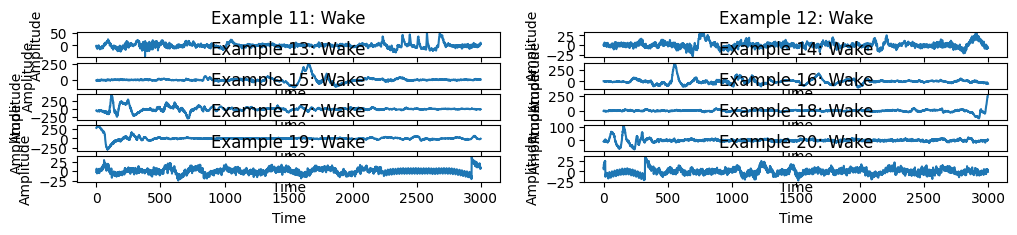

<Figure size 640x480 with 0 Axes>

In [28]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt


# Load the data from the .mat file
filepath = '../data/data.mat'
mat_file = sio.loadmat(filepath)
n_examples = np.shape(mat_file['sig1'])[0]
x = np.zeros((4, n_examples, 3000, 1))
x[0] = mat_file['sig1']
x[1] = mat_file['sig2']
x[2] = mat_file['sig3']
x[3] = mat_file['sig4']


# load labels
labels_file = sio.loadmat('../data/labels.mat')
labels = labels_file['labels'][0].flatten() - 1

sleep_stages = {4: 'Wake', 3: 'REM', 2: 'N1', 1: 'N2', 0: 'N3'}

# convert labels to sleep stages
labels = [sleep_stages[label] for label in labels]



# plot the data from the 10 examples with a for loop and adjust spacing between subplots
plt.figure(figsize=(12, 8))
for i in range(10, 20):
    plt.subplot(20, 2, i+1)
    plt.plot(x[0][i])
    plt.title(f"Example {i+1}: {labels[i]}")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()

plt.show()




plt.tight_layout()


plt.show()





In [12]:
x[0][2].shape, x[1][2].shape, x[2][2].shape, x[3][2].shape

((3000, 1), (3000, 1), (3000, 1), (3000, 1))